In [47]:
import numpy as np
import numba
from plotly import graph_objects as go
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
@numba.njit
def ising_step(field, beta=0.4):
    N, M = field.shape
    for n_offset in range(2):
        for m_offset in range(2):
            for n in range(n_offset, N, 2):
                for m in range(m_offset, M, 2):
                    _ising_update(field, n, m, beta)
    return field


@numba.njit
def _ising_update(field, n, m, beta):
    total = 0
    N, M = field.shape
    for i in range(n-1, n+2):
        for j in range(m-1, m+2):
            if i == n and j == m:
                continue
            total += field[i % N, j % M]
    dE = 2 * field[n, m] * total
    if dE <= 0:
        field[n, m] *= -1
    elif np.exp(-dE * beta) > np.random.rand():
        field[n, m] *= -1

In [74]:

def random_spin_field(N, M):
    return np.random.choice([-1, 1], size=(N, M))

def metropolis_mc(equilibrium_steps=0, sample_size=1000, beta=0.4, size=(700, 700)):
    print('sampling...')
    images = [random_spin_field(size[0], size[1])]
    n_steps=equilibrium_steps + sample_size
    for i in tqdm(range(n_steps)):
        images.append(ising_step(images[-1].copy(), beta=beta))
        if i == equilibrium_steps:
            print('equilibrium is reached')
    return images[equilibrium_steps:]
images = metropolis_mc(beta=1)

sampling...


equilibrium is reached



In [58]:
from PIL import Image

In [59]:
from ipywidgets import interact

def display_ising_sequence(images):
    def _show(frame=(0, len(images) - 1)):
        return display_spin_field(images[frame])
    return interact(_show)

In [75]:
def display_spin_field(field):
    return Image.fromarray(np.uint8((field + 1) * 0.5 * 255))  # 0 ... 255


display_ising_sequence(images)


interactive(children=(IntSlider(value=500, description='frame', max=1000), Output()), _dom_classes=('widget-in…

<function __main__.display_ising_sequence.<locals>._show(frame=(0, 1000))>

In [62]:
@numba.njit
def calcEnergy(config):
    '''Energy of a given configuration'''
    energy = 0
    N = len(config)
    for i in range(len(config)):
        for j in range(len(config)):
            S = config[i,j]
            nb = config[(i+1)%N, j] + config[i,(j+1)%N] + config[(i-1)%N, j]\
                 + config[i,(j-1)%N]
            energy += -nb*S
    return energy/4.

@numba.njit
def calcMag(config):
    '''Magnetization of a given configuration'''
    mag = np.sum(config)
    return mag


In [80]:
Betas = np.exp(np.linspace(np.log(0.12), np.log(0.4), 40))
k_b = 1.3806e-23
sample_size = 500
size = 200
equilibrium_steps = 500

Energies = np.zeros(len(Betas))
Magnetisaisions = np.zeros(len(Betas))
SpecificHeat = np.zeros(len(Betas))
Susceptibility = np.zeros(len(Betas))

n1, n2  = 1.0 / (sample_size * size**2), 1.0 / (sample_size**2 * size**2) 


for idx, cur_beta in tqdm(enumerate(Betas), total=len(Betas)):
    E1 = M1 = E2 = M2 = 0
    
    iT = 1.0 / cur_beta
    iT2 = iT * iT
    
    
    print('beta is {:.5f}'.format(cur_beta))
    for state in metropolis_mc(equilibrium_steps=equilibrium_steps,\
                               sample_size=sample_size, beta=cur_beta, size=(size, size)):
                  
        Ene = calcEnergy(state)     # calculate the energy
        Mag = calcMag(state)        # calculate the magnetisation

        E1 = E1 + Ene
        M1 = M1 + Mag
        M2 = M2 + Mag*Mag 
        E2 = E2 + Ene*Ene

    Energies[idx] = n1 * E1
    Magnetisaisions[idx] = n1 * M1
    SpecificHeat[idx] = (n1 * E2 - n2 * E1 * E1) * iT2
    Susceptibility[idx] = (n1 * M2 - n2 * M1 * M1) * iT


    


beta is 0.12000
sampling...


equilibrium is reached

beta is 0.12376
sampling...


equilibrium is reached

beta is 0.12764
sampling...


equilibrium is reached

beta is 0.13164
sampling...


equilibrium is reached

beta is 0.13577
sampling...


equilibrium is reached

beta is 0.14003
sampling...


equilibrium is reached

beta is 0.14442
sampling...


equilibrium is reached

beta is 0.14895
sampling...


equilibrium is reached

beta is 0.15362
sampling...


equilibrium is reached

beta is 0.15843
sampling...


equilibrium is reached

beta is 0.16340
sampling...


equilibrium is reached

beta is 0.16852
sampling...


equilibrium is reached

beta is 0.17381
sampling...


equilibrium is reached

beta is 0.17926
sampling...


equilibrium is reached

beta is 0.18488
sampling...


equilibrium is reached

beta is 0.19067
sampling...


equilibrium is reached

beta is 0.19665
sampling...


equilibrium is reached

beta is 0.20282
sampling...


equilibrium is reached

beta is 0.20918
sampling...


equilibrium is reached

beta is 0.21573
sampling...


equilibrium is reached

beta is 0.22250
sampling...


equilibrium is reached

beta is 0.22947
sampling...


equilibrium is reached

beta is 0.23667
sampling...


equilibrium is reached

beta is 0.24409
sampling...


equilibrium is reached

beta is 0.25174
sampling...


equilibrium is reached

beta is 0.25963
sampling...


equilibrium is reached

beta is 0.26777
sampling...


equilibrium is reached

beta is 0.27617
sampling...


equilibrium is reached

beta is 0.28483
sampling...


equilibrium is reached

beta is 0.29376
sampling...


equilibrium is reached

beta is 0.30297
sampling...


equilibrium is reached

beta is 0.31247
sampling...


equilibrium is reached

beta is 0.32226
sampling...


equilibrium is reached

beta is 0.33237
sampling...


equilibrium is reached

beta is 0.34279
sampling...


equilibrium is reached

beta is 0.35353
sampling...


equilibrium is reached

beta is 0.36462
sampling...


equilibrium is reached

beta is 0.37605
sampling...


equilibrium is reached

beta is 0.38784
sampling...


equilibrium is reached

beta is 0.40000
sampling...


equilibrium is reached




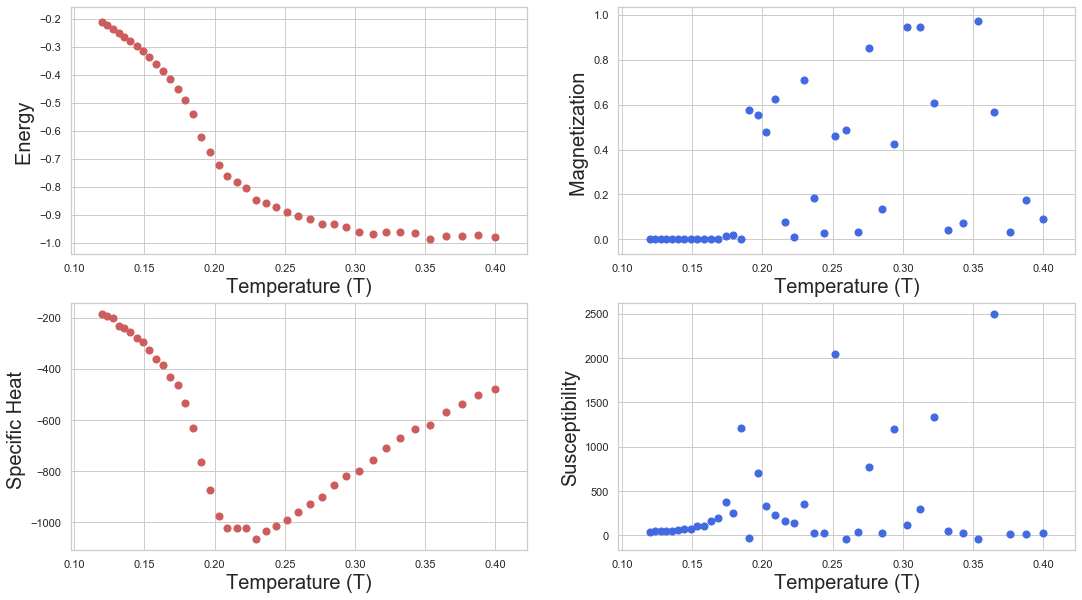

In [82]:
f = plt.figure(figsize=(18, 10)); # plot the calculated values    

sp =  f.add_subplot(2, 2, 1 );
plt.scatter(Betas, Energies, s=50, marker='o', color='IndianRed')
plt.xlabel("Temperature (T)", fontsize=20);
plt.ylabel("Energy ", fontsize=20);         plt.axis('tight');

sp =  f.add_subplot(2, 2, 2 );
plt.scatter(Betas, abs(Magnetisaisions), s=50, marker='o', color='RoyalBlue')
plt.xlabel("Temperature (T)", fontsize=20); 
plt.ylabel("Magnetization ", fontsize=20);   plt.axis('tight');

sp =  f.add_subplot(2, 2, 3 );
plt.scatter(Betas, SpecificHeat, s=50, marker='o', color='IndianRed')
plt.xlabel("Temperature (T)", fontsize=20);  
plt.ylabel("Specific Heat ", fontsize=20);   plt.axis('tight');   

sp =  f.add_subplot(2, 2, 4 );
plt.scatter(Betas, Susceptibility, s=50, marker='o', color='RoyalBlue')
plt.xlabel("Temperature (T)", fontsize=20); 
plt.ylabel("Susceptibility", fontsize=20);   plt.axis('tight');

In [70]:
len(Betas), len(Energies)

(40, 1000)